In [ ]:
import pandas as pd
from textwrap import dedent
import time
from openai import OpenAI
import json
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Get configuration from environment variables
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
gpt_model = os.getenv("GPT_MODEL", "gpt-4o-mini")  # Default to gpt-4o-mini if not set

In [16]:
role = dedent(
    f"""\
    Anda adalah seorang Analis Riset yang mengkhususkan diri dalam analisis sentimen pada konten media sosial. Tugas Anda adalah menganalisis teks secara akurat untuk mengidentifikasi sentimen (positif, negatif, atau netral).\n
    Anda mahir dalam menggunakan teknologi AI tingkat lanjut untuk menganalisis teks dan konteks secara efektif. Anda memiliki pemahaman mendalam terhadap bahasa, istilah, dan referensi yang umum digunakan dalam diskursus politik.\n
    Selain itu, Anda juga memiliki kemampuan dalam memahami dialek dan bahasa lokal, termasuk bahasa Indonesia, sehingga mampu menginterpretasikan dan menganalisis konten media sosial dengan akurat.\n
    Fokus analisis Anda adalah mengidentifikasi sentimen secara keseluruhan.
    """
)


def _analyze_sentiment(text):
    task = dedent(
        f"""\    
        Analisis sentimen dari teks berikut.\n 
        Berikan hasil analisis sentimen sebagai salah satu dari: 'positif', 'netral', atau 'negatif'.\n 
        Jawaban dalam format JSON berikut: {{'sentimen': 'positif' | 'netral' | 'negatif'}}.
        """
    )

    messages = [
        {"role": "system", "content": f"Role: {role}"},
        {"role": "user", "content": f"Task: {task}"},
        {"role": "user", "content": f"Text: {text}"},
    ]


    completion = client.chat.completions.create(
        model=gpt_model,
        temperature=0.7,
        messages=messages,
        timeout=60,
        response_format={"type": "json_object"},
    )

    response = completion.choices[0].message.content
    print(f"Response: {response}")
    response_json = json.loads(response)
    sentiment = response_json["sentimen"].lower()
    return sentiment if sentiment in ['positif','negatif','netral','campuran'] else "unknown"

def sentiment_analysis(csv_file):

    df = pd.read_csv(csv_file, encoding="utf-8")

    if "sentimen" not in df.columns:
        df["sentimen"] = ""

    print(f"Total profiles to analyze: {len(df)}")

    progress = 0
    for index, row in df.iterrows():
        progress += 1

        text = row['teks']

        print(f"\nProcessing Profile: [{progress}/{len(df)}]")

        sentiment = _analyze_sentiment(text)

        df.loc[index, "sentimen"] = sentiment

        time.sleep(0.5)

    csv_filename = csv_file.replace(".csv", "")
    df.to_csv(f"{csv_filename}_marked_deepseek.csv", index=False, encoding="utf-8")
    return df


In [17]:
import pandas as pd
df = sentiment_analysis("temp/bank_sentiment_test.csv")

Total profiles to analyze: 900

Processing Profile: [1/900]
Response: {"sentimen": "positif"}

Processing Profile: [2/900]
Response: {"sentimen": "positif"}

Processing Profile: [3/900]
Response: {"sentimen": "positif"}

Processing Profile: [4/900]
Response: {"sentimen":"netral"}

Processing Profile: [5/900]
Response: {"sentimen": "netral"}

Processing Profile: [6/900]
Response: {"sentimen": "netral"}

Processing Profile: [7/900]
Response: {"sentimen": "positif"}

Processing Profile: [8/900]
Response: {"sentimen": "positif"}

Processing Profile: [9/900]
Response: {"sentimen": "positif"}

Processing Profile: [10/900]
Response: {"sentimen": "negatif"}

Processing Profile: [11/900]
Response: {"sentimen": "negatif"}

Processing Profile: [12/900]
Response: {"sentimen": "positif"}

Processing Profile: [13/900]
Response: {"sentimen": "positif"}

Processing Profile: [14/900]
Response: {"sentimen": "netral"}

Processing Profile: [15/900]
Response: {"sentimen": "positif"}

Processing Profile: [1

# With Context Company

In [20]:
role = dedent(
    f"""\
    Anda adalah seorang Analis Riset yang mengkhususkan diri dalam analisis sentimen pada konten media sosial. Tugas Anda adalah menganalisis teks secara akurat untuk mengidentifikasi sentimen (positif, negatif, netral, atau campuran).\n
    Anda mahir dalam menggunakan teknologi AI tingkat lanjut untuk menganalisis teks dan konteks secara efektif. Anda memiliki pemahaman mendalam terhadap bahasa, istilah, dan referensi yang umum digunakan dalam diskursus politik.\n
    Selain itu, Anda juga memiliki kemampuan dalam memahami dialek dan bahasa lokal, termasuk bahasa Indonesia, sehingga mampu menginterpretasikan dan menganalisis konten media sosial dengan akurat.\n
    Fokus analisis Anda adalah mengidentifikasi sentimen secara keseluruhan.
    """
)


def _analyze_sentiment_with_context(text, context):
    task_with_context = dedent(
        f"""\    
        Analisis sentimen dari teks berikut terhadap entitas yang menjadi fokus: {context}.\n
        Berikan hasil analisis sentimen sebagai salah satu dari: 'positif', 'netral', atau 'negatif'.\n
        Jika sentimen bersifat negatif terhadap perusahaan lain, terutama yang merupakan pesaing dari {context}, maka klasifikasikan sentimen tersebut sebagai 'positif' terhadap {context}.\n
        Sebaliknya, jika sentimen bersifat positif terhadap perusahaan lain, terutama pesaing dari {context}, maka klasifikasikan sentimen tersebut sebagai 'negatif' terhadap {context}.\n
        Jika sentiment bersifat positif dan negatif terhadap {context}, maka klasifikasikan sebagai 'campuran'.\n
        Jawaban dalam format JSON berikut: {{'sentimen': 'positif' | 'netral' | 'negatif' | 'campuran'}}.
        """
    )

    messages = [
        {"role": "system", "content": f"Role: {role}"},
        {"role": "user", "content": f"Task: {task_with_context}"},
        {"role": "user", "content": f"Text: {text}"},
        {"role": "user", "content": f"Context: {context}"}
    ]


    completion = client.chat.completions.create(
        model=gpt_model,
        temperature=0.7,
        messages=messages,
        timeout=60,
        response_format={"type": "json_object"},
    )

    response = completion.choices[0].message.content
    print(f"Response: {response}")
    response_json = json.loads(response)
    sentiment = response_json["sentimen"].lower()
    return sentiment if sentiment in ['positif','negatif','netral','campuran'] else "unknown"

def sentiment_analysis_with_context(csv_file):

    df = pd.read_csv(csv_file, encoding="utf-8")

    if "sentimen" not in df.columns:
        df["sentimen"] = ""

    print(f"Total profiles to analyze: {len(df)}")

    progress = 0
    for index, row in df.iterrows():
        progress += 1

        text = row['teks']
        context = row['target_bank']

        print(f"\nProcessing Profile: [{progress}/{len(df)}]")

        sentiment = _analyze_sentiment_with_context(text, context)

        df.loc[index, "sentimen"] = sentiment

        time.sleep(0.2)

    csv_filename = csv_file.replace(".csv", "")
    df.to_csv(f"{csv_filename}_marked_deepseek_with_context.csv", index=False, encoding="utf-8")
    return df


In [21]:
import pandas as pd
df = sentiment_analysis_with_context("temp/bank_sentiment_test.csv")

Total profiles to analyze: 900

Processing Profile: [1/900]
Response: {
  "sentimen": "campuran"
}

Processing Profile: [2/900]
Response: {"sentimen": "positif"}

Processing Profile: [3/900]
Response: {
  "sentimen": "campuran"
}

Processing Profile: [4/900]
Response: {
  "sentimen": "netral"
}

Processing Profile: [5/900]
Response: {
  "sentimen": "negatif"
}

Processing Profile: [6/900]
Response: {"sentimen": "campuran"}

Processing Profile: [7/900]
Response: {
  "sentimen": "campuran"
}

Processing Profile: [8/900]
Response: {"sentimen": "positif"}

Processing Profile: [9/900]
Response: {"sentimen": "positif"}

Processing Profile: [10/900]
Response: {
  "sentimen": "negatif"
}

Processing Profile: [11/900]
Response: {"sentimen": "positif"}

Processing Profile: [12/900]
Response: {"sentimen": "positif"}

Processing Profile: [13/900]
Response: {"sentimen": "campuran"}

Processing Profile: [14/900]
Response: {
  "sentimen": "positif"
}

Processing Profile: [15/900]
Response: {"sentimen

# Analyze Evaluation

In [22]:
import pandas as pd
df = pd.read_csv("temp/bank_sentiment_test_marked_deepseek_with_context.csv", encoding="utf-8")
df['label'] = pd.read_csv('temp/bank_sentiment_test.csv', encoding='utf-8')['sentimen']
df['context'] = pd.read_csv('temp/bank_sentiment_test.csv', encoding='utf-8')['target_bank']

In [23]:
from sklearn.metrics import f1_score

accuracy = (df['sentimen'] == df['label']).mean()
f1_macro = f1_score(df['label'], df['sentimen'], average='macro')
f1_weighted = f1_score(df['label'], df['sentimen'], average='weighted')

print(f"Accuracy of sentiment analysis: {accuracy:.2%}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")

Accuracy of sentiment analysis: 92.44%
F1 Score (macro): 0.9026
F1 Score (weighted): 0.9236


In [49]:
for i, row in df_non_campuran[df_non_campuran['label']!=df_non_campuran['sentimen']].iterrows():
    print(f"Comment: {row['teks']}\nLabel: {row['label']}\nSentiment: {row['sentimen']}\nContext: {row['context']}\n")

Comment: Belakangan, waktu mau bayar tagihan, gak ada setoran awal minimum yang besar untuk buka tabungan di Bank BNI. Bank BNI gak sebagus Bank BRI sih.
Label: negatif
Sentiment: positif
Context: Bank BRI

Comment: Dari tadi pagi, saat gajian, aplikasi BNI Mobile Banking-nya sangat intuitif dan mudah digunakan, bahkan buat pemula. Bank BNI masih kalah sama Bank Mandiri sih.
Label: negatif
Sentiment: positif
Context: Bank Mandiri

Comment: anak saya baru buka tabungan pelajar di Bank BCA minggu lalu.
Label: netral
Sentiment: positif
Context: Bank BCA

Comment: Kalau dari segi biaya, kalau transfer ke sesama Bank Mandiri gratis, jadi sering kupakai. Tapi kalau cs, walaupun antre, pelayanan di teller Bank BNI efisien dan cepat. Susah milihnya.
Label: positif
Sentiment: campuran
Context: Bank BNI

Comment: Bank BNI buka cabang baru di deket rumah saya tadi.
Label: netral
Sentiment: positif
Context: Bank BNI

Comment: Kalau dari segi pembukaan_rekening, onboarding di Bank BCA dikasih welco

In [40]:
df_campuran = df[df['label']=='campuran']

for i, row in df_campuran[df_campuran['label']!=df_campuran['sentimen']].iterrows():
    print(f"Comment: {row['teks']}\nLabel: {row['label']}\nSentiment: {row['sentimen']}\nContext: {row['context']}\n")


Comment: Honestly, Bank Mandiri overall bagus, tabungan Bank Mandiri gak ada minimum saldo yang memberatkan dan pengalaman saya dengan customer service Bank Mandiri selalu baik dan solutif, sayangnya pernah ada kasus double charge di kartu kredit Bank Mandiri.
Label: campuran
Sentiment: positif
Context: Bank Mandiri

Comment: Pengalaman pribadiku sih, Bank BNI overall bagus, gak ada setoran awal minimum yang besar untuk buka tabungan di Bank BNI dan teknologi AI di Bank BNI membantu deteksi fraud dengan akurat, sayangnya WiFi gratis di Bank BNI lemot dan sering putus.
Label: campuran
Sentiment: positif
Context: Bank BNI

Comment: Jujur, Bank BCA overall bagus, robo advisor Bank BCA membantu pilih portofolio yang tepat dan petugas di kantor cabang Bank BCA ramah-ramah dan informatif, tapi night mode myBCA malah bikin mata pusing, kontras kurang.
Label: campuran
Sentiment: positif
Context: Bank BCA

Comment: Menurutku, Bank BNI overall bagus, petugas di kantor cabang Bank BNI ramah-ramah

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
true_labels = df['label'].tolist()
predicted_labels = df['sentimen'].tolist()
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

    campuran       0.80      0.97      0.88        59
     negatif       0.96      0.94      0.95        84
      netral       0.94      0.73      0.82        22
     positif       0.91      0.87      0.89       135

    accuracy                           0.90       300
   macro avg       0.90      0.88      0.88       300
weighted avg       0.91      0.90      0.90       300



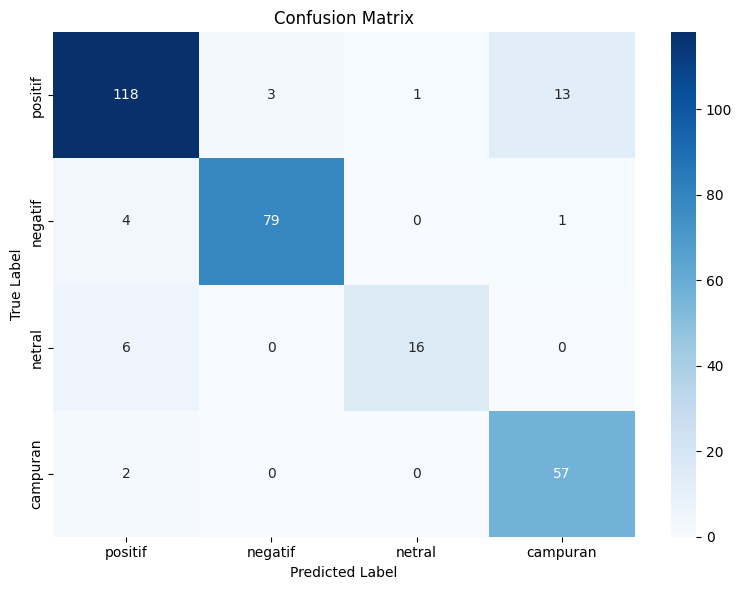

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
labels = ['positif', 'negatif', 'netral', 'campuran']

cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
        
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
df = pd.read_csv("temp/prediction_deepseek_with_context.csv", encoding="utf-8")
prediction = pd.read_csv("temp/test_dataset_predictions.csv", encoding="utf-8")

df['sentimen'] = prediction['predicted_label']

df

,teks,target_bank,sentimen
0,"Jujur, Bank Mandiri overall bagus, reksadana d...",Bank Mandiri,campuran
1,"Kalau boleh jujur, ATM Bank BCA ada fitur tari...",Bank BCA,positif
2,"Menurutku, Bank BNI overall bagus, API Bank BN...",Bank BNI,campuran
3,"Lagi compare Bank Mandiri vs Bank BNI, ada mas...",Bank Mandiri,netral
4,Layar atm bank bri jernih dan touchscreen-nya ...,Bank BNI,negatif
...,...,...,...
895,"Kemarin, pas weekend, inovasi fintech Bank BCA...",Bank BCA,positif
896,Dari tadi pagi CS di social media Bank BNI bal...,Bank BNI,negatif
897,"Kalau boleh jujur, biaya admin bulanannya wort...",Bank BCA,negatif
898,"Sebagai yang ganti dari bank konvensional, sat...",Bank Mandiri,positif


In [9]:
df.to_csv("temp/prediction_indobert_finetuned.csv", index=False, encoding="utf-8")